# **ETS Analysis**

This data analysis project involves analyzing data related to the ETS, such as emissions data from regulated entities and allocation data of emission allowances. The project aims to explore trends in emissions over time, identify sectors that are emitting high amounts of greenhouse gases, and evaluate the effectiveness of the ETS in reducing emissions. The project involves visualizing the data to communicate insights to stakeholders and policymakers. The data of this project has been retrieved from https://www.eea.europa.eu/data-and-maps/dashboards/emissions-trading-viewer-1, the EU Emissions Trading System (ETS) data viewer from the European Environment Agency.

Greenhouse gas emissions are a major contributor to climate change and have significant impacts on the environment, human health and well-being, and the economy. By understanding the sources and trends of emissions, policymakers and stakeholders can develop effective strategies and policies to reduce emissions and mitigate climate change.
Exploring the emissions dataset can help identify patterns and trends in emissions across different sectors and countries. This information can be useful for identifying areas where emissions reductions can have the greatest impact, and for monitoring progress towards emissions reduction targets.

<br>

# Setup

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

%load_ext autoreload
%autoreload 2

from dataproject import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<br>

# Read and clean data

In this code block, we are reading in a dataset called "ETS_Database_v49_Jul22.csv" and cleaning it using the function 'clean_ets', that has been constructed at 'dataproject.py'. The cleaned dataset is then split into two separate dataframes based on their category: allocations and emissions. The copy() function is used to create separate copies of each dataframe, so that any changes made to one dataframe will not affect the other. Finally, the original dataset and the two separate dataframes are displayed using the display() function.

In [22]:
# read data set
ets = clean_ets(pd.read_csv('ETS_Database_v49_Jul22.csv', sep='\t'))

# seperate into categories, using copies to prevent unintended changes
allocations = ets.loc[ets['category'].str.startswith('1.')].copy()
emissions = ets.loc[ets['category'].str.startswith('2.')].copy()

display(ets)

,country,country_code,category,sector,value,year
0,Austria,AT,1.1.1 Free allocation to existing entities (Ar...,32 Manufacture of ceramics,481340.0,2011
1,Austria,AT,1.1.1 Free allocation to existing entities (Ar...,32 Manufacture of ceramics,478462.0,2012
2,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2017
3,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2018
4,Austria,AT,1.1.2 Free allocation from the new entrants re...,32 Manufacture of ceramics,0.0,2021
...,...,...,...,...,...,...
33049,Slovenia,SI,2.1 EU-ETS Verified Emission,24 Production of pig iron or steel,217488.0,2016
33050,Slovenia,SI,2.1 EU-ETS Verified Emission,24 Production of pig iron or steel,222518.0,2019
33051,Slovenia,SI,4.2 Surrendered certified emission reductions ...,24 Production of pig iron or steel,0.0,2011
33052,Slovenia,SI,4.2 Surrendered certified emission reductions ...,24 Production of pig iron or steel,0.0,2012


<br>

# Explore each data set

### Emissions

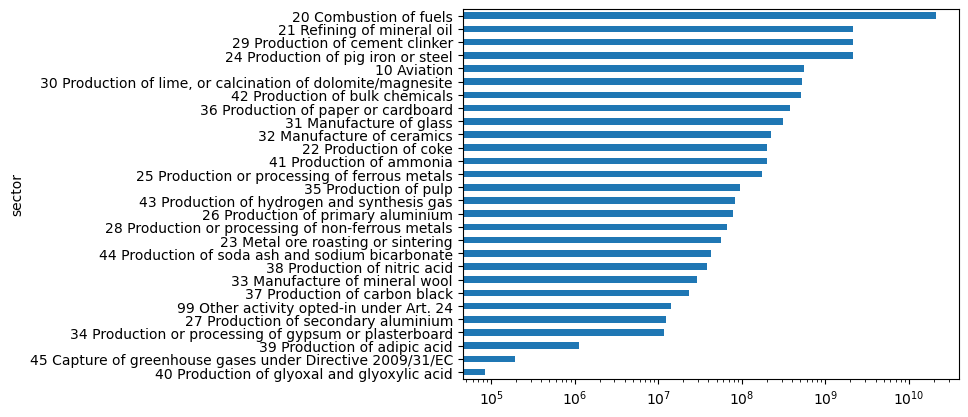

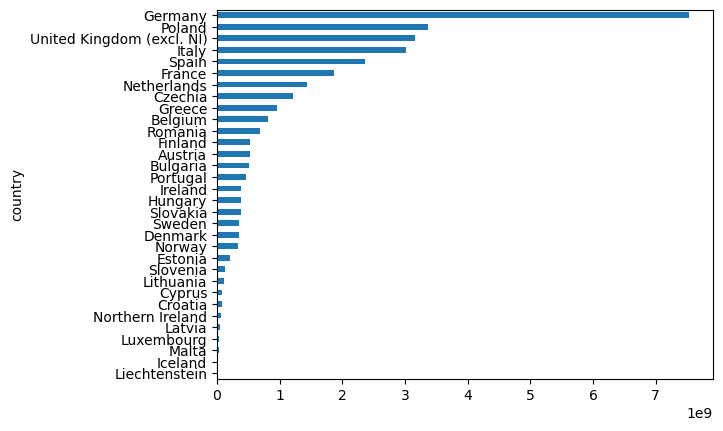

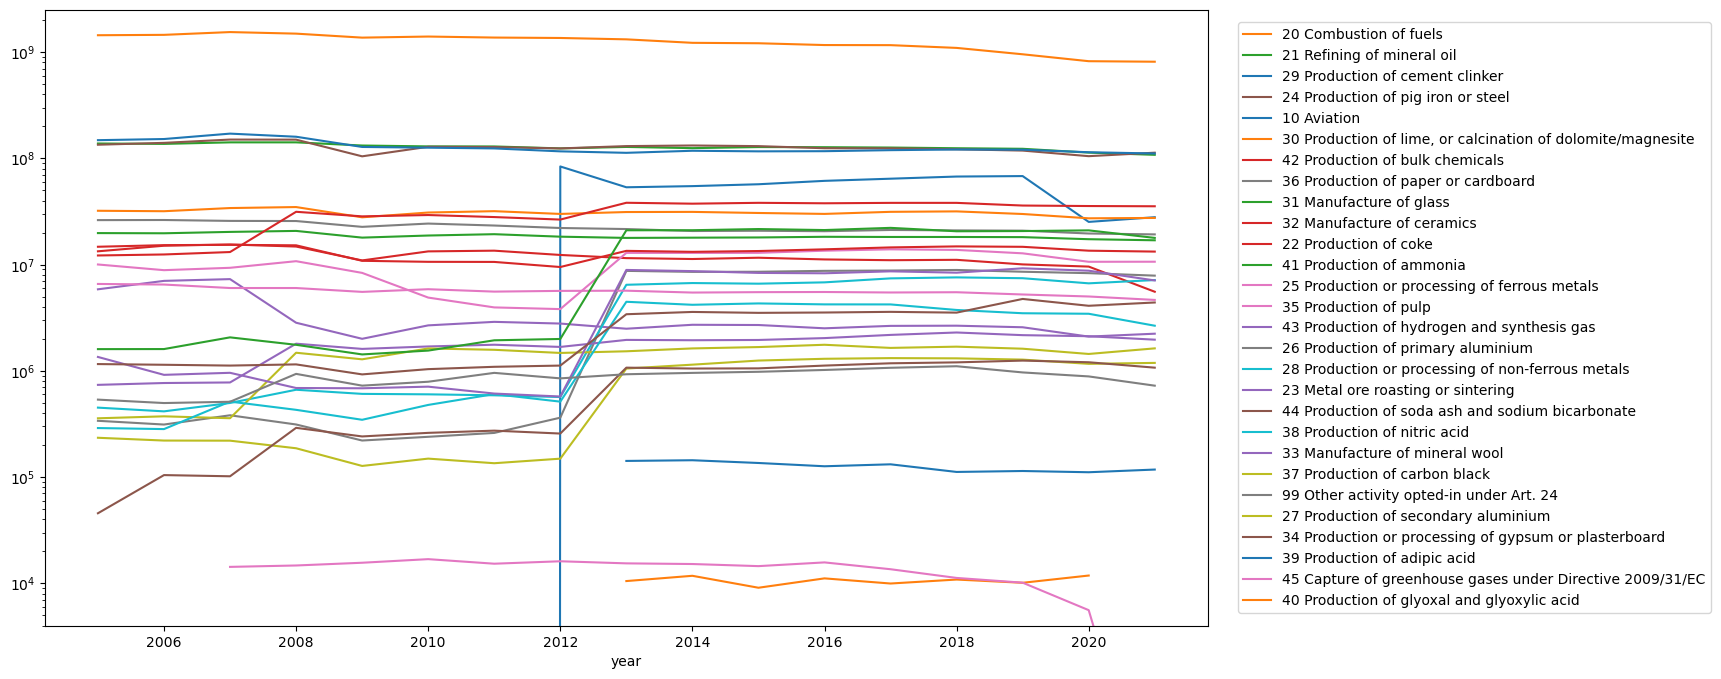

In [23]:
# by sector
emsh_by_sector = emissions.groupby('sector')['value'].apply('sum')
emsh_by_sector.sort_values(inplace=True)
plt.figure(); emsh_by_sector.plot(kind='barh', logx=True)

# by country
emsh_by_country = emissions.groupby('country')['value'].apply('sum')
emsh_by_country.sort_values(inplace=True)
plt.figure(); emsh_by_country.plot(kind='barh')

# by sector over time
emsh_by_sector_t = emissions.groupby(['sector', 'year'])['value'].apply('sum').reset_index(); 
fig, ax = plt.subplots(figsize=(15,8))
for name, sector in emsh_by_sector_t.groupby('sector'): sector.plot(ax=ax, x='year', y='value', label=name, logy=True, ylim=(10**3.6, 10**9.4))
sort_legend(ax, key=lambda label: emsh_by_sector[label], reverse=True, bbox_to_anchor=(1.02,0.5), loc='center left')

Here we have that the first image shows the total emissions of each sector summed up. It is a horizontal bar chart, where the length of the bar represents the total emissions of the sector. The second graph shows the total emissions of each country. It is also a horizontal bar chart, where the length of the bar represents the total emissions of the country, is possible to see that the biggest emitter is Germany. The third graph is a different visualization of the same contents as the first graph, showing the total emissions of each sector over time. It is now a line chart, where each line represents a sector, and the x-axis shows the years.

<br>

### Allocations

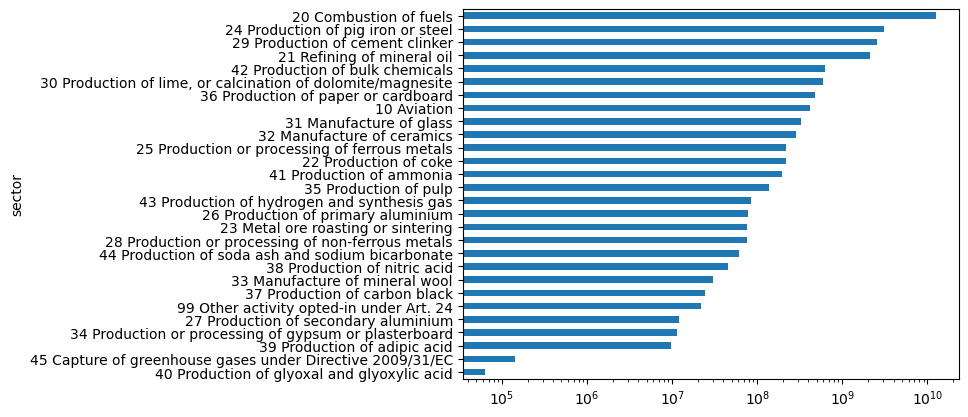

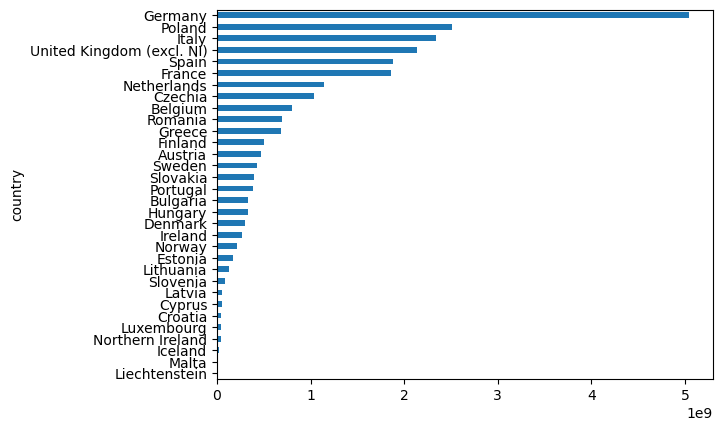

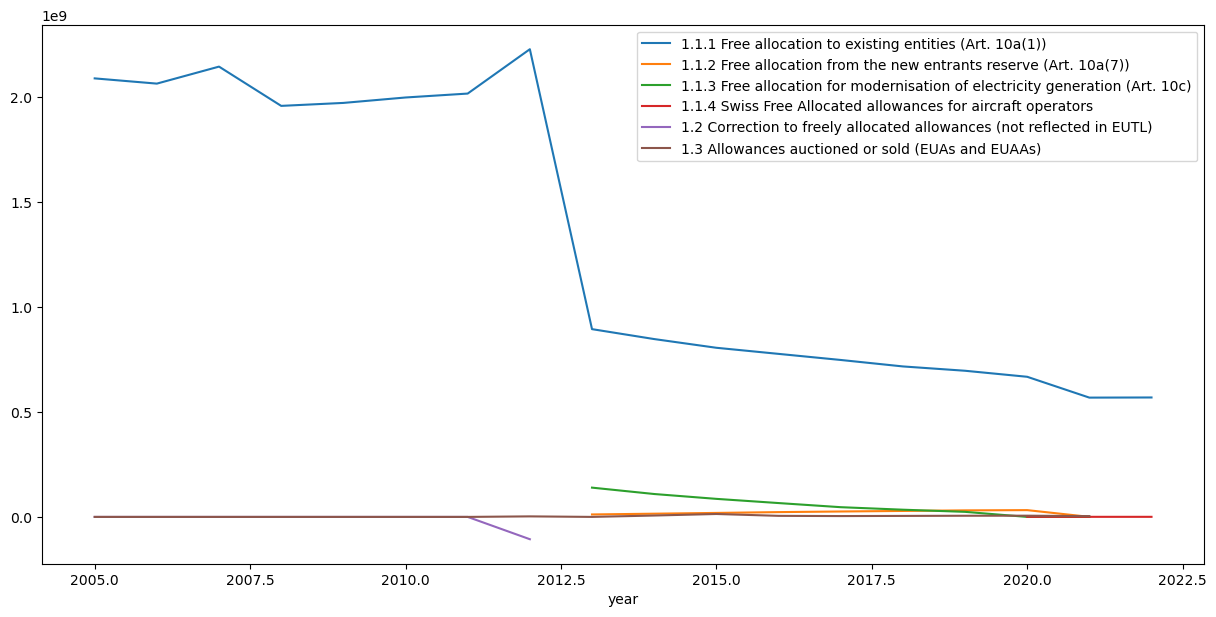

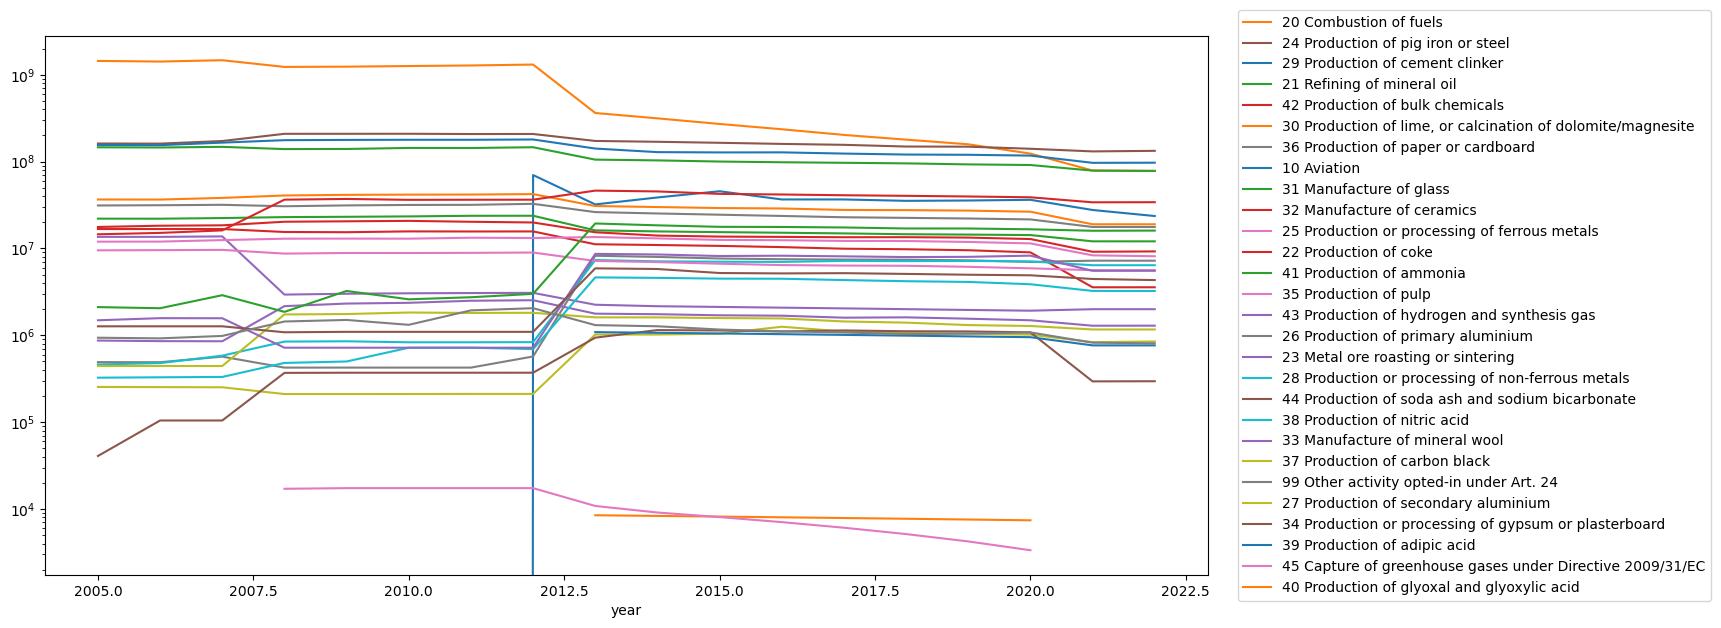

In [24]:
# by sector
aloc_by_sector = allocations.groupby('sector')['value'].apply('sum')
aloc_by_sector.sort_values(inplace=True)
plt.figure(); aloc_by_sector.plot(kind='barh', logx=True)

# by country
aloc_by_country = allocations.groupby('country')['value'].apply('sum')
aloc_by_country.sort_values(inplace=True)
plt.figure(); aloc_by_country.plot(kind='barh')

# by category over time
aloc_by_category_t = allocations.groupby(['category', 'year'])['value'].apply('sum').reset_index(); 
fig, ax = plt.subplots(figsize=(15,7))
for name, category in aloc_by_category_t.groupby('category'): category.plot(ax=ax, x='year', y='value', label=name)

# by sector over time
aloc_by_sector_t = allocations.groupby(['sector', 'year'])['value'].apply('sum').reset_index(); 
fig, ax = plt.subplots(figsize=(15,7))
for name, sector in aloc_by_sector_t.groupby('sector'): sector.plot(ax=ax, x='year', y='value', label=name, logy=True)
sort_legend(ax, key=lambda label: aloc_by_sector[label], reverse=True, bbox_to_anchor=(1.02,0.5), loc='center left')

The first graph shows the total allocations for each sector. The x-axis is on a logarithmic scale, which means that the values increase exponentially. Sectors with higher allocations will be placed further to the right of the graph.
The second graph shows the total allocations for each country. Countries with higher allocations will be placed further to the right of the graph.
The third graph shows the total allocations for each category over time. The categories are grouped based on the type of allocation.
The fourth graph shows the total allocations for each sector over time. The x-axis represents the year and the y-axis shows the total allocations on a logarithmic scale. The legend is sorted in descending order of total allocations to make it easier to compare the sectors. 

<br><br>

# Analysis

### Emissions by country over time, indexed

In [25]:
emsh_by_country_t = emissions.groupby(['country', 'year'])['value'].apply('sum').reset_index()

In [26]:
# identify index: second nonzero entry for country
countries = emissions['country'].unique()
years = emissions['year'].unique(); years.sort()
indexes = {}

for country in countries:
    country_data = emsh_by_country_t.loc[emsh_by_country_t['country']==country]
    counter = 0

    for year in years:
        value = country_data.loc[country_data['year'] == year]['value']
        if value.empty or value.item()==0: continue
        counter += 1
        if counter >= 2: break

    indexes[country] = value.item()


# create new column with indexed values
def relative_to_index(df): return df['value'] / indexes[df.name]
emsh_by_country_t['value_indexed'] = emsh_by_country_t.groupby('country', group_keys=False).apply(relative_to_index)

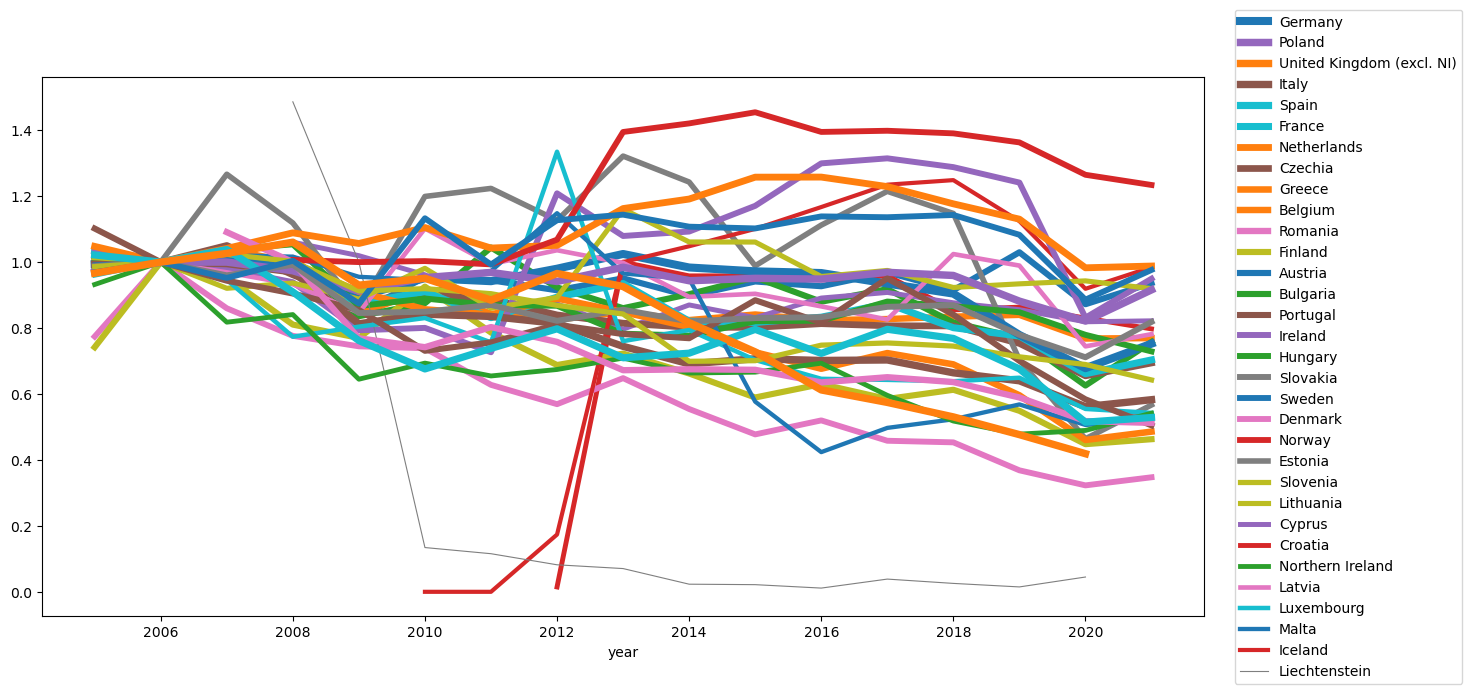

In [27]:
# create plot, line thickness captures country emissions
country_weights = stretch_series(emsh_by_country, pow=0.05, span=5, lb=0.8)
fig, ax = plt.subplots(figsize=(15,7))
for name, country in emsh_by_country_t.groupby('country'): country.plot(ax=ax, x='year', y='value_indexed', label=name, lw=country_weights[name])
sort_legend(ax, key=lambda label: emsh_by_country[label], reverse=True, bbox_to_anchor=(1.02,0.5), loc='center left')

The code creates a plot with line thickness representing the emissions of each country over time. First, it calculates the weights for each country based on their total emissions using the 'stretch_series' function. Then, it plots each country's emissions over time using the 'emsh_by_country_t' DataFrame, which is the output of another previous aggregation done on the emissions DataFrame.

The resulting plot shows the emissions over time for each country, with thicker lines representing higher-emitting countries. The legend is sorted by the total emissions of each country, with the highest-emitting countries at the top.
The y-axis is the "value_indexed" column, which is the emission value for a particular country and year divided by the sum of the emissions for that country across all years, and then multiplied by 100 to get a percentage. In other words, it shows the proportion of a country's emissions in a given year, second non-zero entry of each country, relative to its total emissions over all years in the dataset.

The plot indicates that Germany is the biggest total emitter once again, however Norway has a higher indexed emission value, which indicates that their country's emissions are higher than the average emissions of all countries.

<br>

### Change in emissions against change in allocations by sector

In [28]:
# drop zeros and merge
emsh_by_sector_t_0 = emsh_by_sector_t.loc[emsh_by_sector_t['value']!=0]
aloc_by_sector_t_0 = aloc_by_sector_t.loc[aloc_by_sector_t['value']!=0]
sector_emsh_aloc = pd.merge(emsh_by_sector_t_0, aloc_by_sector_t_0, on=['year', 'sector'], how='inner', suffixes=('_emissions', '_allocation'))

# take logs
sector_emsh_aloc['log_emissions'] = np.log(sector_emsh_aloc['value_emissions'])
sector_emsh_aloc['log_allocation'] = np.log(sector_emsh_aloc['value_allocation'])

# find change in logs
mean_diff = lambda x: np.mean(x.diff())
sector_changes = sector_emsh_aloc.groupby('sector').agg({'log_emissions':[mean_diff],'log_allocation':mean_diff})
sector_changes.columns = ['md_log_emissions', 'md_log_allocation']

# include emissions by sector
sector_changes['emissions'] = stretch_series(emsh_by_sector, pow=1, span=500, lb=10)

# plot
fig, ax = plt.subplots(figsize=(10,7))
for name, sector in sector_changes.groupby('sector'):
    sector.plot(ax=ax, kind='scatter', x='md_log_allocation', y='md_log_emissions', s='emissions', label=name, color=[[random_colour()]])
sort_legend(ax, key=lambda label: emsh_by_sector[label], reverse=True, bbox_to_anchor=(1.02,0.5), loc='center left')

NameError: name 'both' is not defined